### Name: Riya Shyam Huddar
### Roll no: MDS202431
### NLP Assignment 2

In [ ]:
#Imports
import numpy as np
import pandas as pd
import json
from joblib import Parallel, delayed
import multiprocessing
import time
import os
import psutil
import re
import string
from collections import Counter
from collections import defaultdict
import stopwordsiso as stopwords
from numpy.linalg import svd
from numpy.linalg import norm
import matplotlib.pyplot as plt

In [ ]:
!pip install stopwordsiso

----

### Preprocessing

Firstly, it's important to understand the computational resources available. This helps us decide:
- The vocabulary size we can handle.
- Appropriate usage of parallel processing
- Memory considerations for storing large co-occurrence matrices.

In [ ]:
print(f"Number of CPU cores: {os.cpu_count()}")

# CPU speed is reported in MHz, convert to GHz
cpu_freq = psutil.cpu_freq()
print(f"CPU Speed: {cpu_freq.max / 1000:.2f} GHz")

# Memory is in bytes, convert to GB
print(f"Memory: {psutil.virtual_memory().total / 1e9:.2f} GB")


Number of CPU cores: 12
CPU Speed: 1.30 GHz
Memory: 16.88 GB


### Cleaning the Marathi Corpus

For this assignment, we are using the **Marathi** corpus.  

The corpus being used was already cleaned in **Assignment 1**, but to ensure accuracy for this analysis, we perform additional cleaning:

1. **Script-specific numbers**: Marathi uses Devanagari digits (०-९), which we remove to avoid noise in the embeddings.
2. **ASCII digits**: Standard 0–9 digits are removed.
3. **Punctuation**: Both ASCII punctuation and Marathi-specific punctuation marks (`।`, `॥`, quotation marks, dashes, etc.) are removed.
4. **Token validation**: Only tokens containing at least one Devanagari character are retained, and tokens that are purely numeric are discarded.

This ensures that the corpus used for co-occurrence matrix computation contains **valid Marathi words**, improving the quality of both sparse and dense embeddings.


In [ ]:
# Clean Marathi corpus to remove punctuations and numbers
def clean_marathi_corpus(input_path, output_path):
    # Define punctuation to remove (ASCII + Marathi-specific)
    all_punct = string.punctuation + "।॥“”‘’—–"

    # Define Devanagari digits (०-९) and ASCII digits (0-9)
    all_digits = "०१२३४५६७८९" + string.digits

    # Check if valid Marathi token (Devanagari letters only, no digits)
    def is_valid_token_mr(token):
        # Must contain at least one Devanagari char, and not be pure digits
        return bool(re.search(r'[\u0900-\u097F]', token)) and not re.fullmatch(r'[\d०-९]+', token)

    word_counts = Counter()

    with open(input_path, 'r', encoding='utf-8') as f_in, \
         open(output_path, 'w', encoding='utf-8') as f_out:

        for line in f_in:
            line = line.strip()
            if not line:
                continue

            tokens = line.split()

            # Remove punctuation and digits
            cleaned_tokens = [
                t.translate(str.maketrans('', '', all_punct + all_digits))
                for t in tokens
            ]

            # Keep only valid tokens
            cleaned_tokens = [t for t in cleaned_tokens if is_valid_token_mr(t)]

            # Update word counts
            word_counts.update(cleaned_tokens)

            if cleaned_tokens:
                f_out.write(" ".join(cleaned_tokens) + "\n")

    print(f"Fully cleaned Marathi corpus saved to: {output_path}")
    print(f"Total unique words in cleaned corpus: {len(word_counts)}")
    print("Top 20 words:", word_counts.most_common(20))

    return word_counts


We save the updated clean corpus on local machine.

In [ ]:
# Clean the Marathi corpus and save the updated version
input_path = "D:/CMI/NLP/mrwiki_corpus_cleaned.txt"
output_path = "D:/CMI/NLP/mrwiki_corpus_cleaned_updated.txt"

word_counts = clean_marathi_corpus(input_path, output_path)


Fully cleaned Marathi corpus saved to: D:/CMI/NLP/mrwiki_corpus_cleaned_updated.txt
Total unique words in cleaned corpus: 718524
Top 20 words: [('आणि', 261635), ('आहे', 261499), ('या', 149215), ('हे', 137602), ('व', 117368), ('एक', 101263), ('ते', 95927), ('हा', 88186), ('पुनर्निर्देशन', 77186), ('होते', 65949), ('मध्ये', 64461), ('आहेत', 64430), ('केले', 61389), ('ही', 59843), ('येथे', 58718), ('जिल्ह्यातील', 53862), ('इस', 50062), ('तालुक्यातील', 49517), ('गावे', 49275), ('केली', 48595)]


In [ ]:
# Helper function to count vocabulary and tokens from a file
def vocab_token_count(file_path):
    # Read the file
    with open(file_path, "r", encoding="utf-8") as f:
        words = f.read().split()  # split by whitespace

    # Count tokens and vocab
    num_tokens = len(words)
    vocab = set(words)
    num_vocab = len(vocab)
    return num_tokens,num_vocab



The cleaned Marathi corpus contains **15,091,613 tokens**, and the vocabulary size is **718,524**


In [ ]:
num_tokens,num_vocab=vocab_token_count(output_path)

# Print results
print(f"Number of tokens: {num_tokens}")
print(f"Vocabulary size: {num_vocab}")


Number of tokens: 15091613
Vocabulary size: 718524


In [ ]:
# Reads a cleaned corpus file and returns a list of all tokens.
def create_tokens_var(path):
    tokens = []
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            line_tokens = line.strip().split()  # whitespace tokenization
            tokens.extend(line_tokens)
    print(f"Number of tokens in cleaned corpus: {len(tokens)}")
    return tokens

In [ ]:
tokens=create_tokens_var(output_path)

Number of tokens in cleaned corpus: 15091613


### Removing Marathi Stopwords

To further refine the corpus, we remove **common Marathi stopwords**.  

Stopwords are frequent words (like 'अधिक' (more), 'अनेक' (many), 'अशी' (such), 'असलयाचे' (to be)) that usually do not contribute meaningful semantic information for word embeddings. Removing them helps:

>1. Reduce noise in the co-occurrence matrix and improve the quality of the corpus.  
>2. Lower memory requirements since the vocabulary is slightly reduced.

**Note:** The inflectional richness of Marathi (for example, 'असलयाचे' (to be), 'असलेल्या' (that existed), 'असा' (such), 'असून' (being)) poses challenges for stemming and lemmatization. Due to these language-specific characteristics, accurate morphological processing is complicated.


In [ ]:
# Load Marathi stopwords
marathi_stopwords = stopwords.stopwords("mr")

# Convert to a sorted list
marathi_stopwords_list = sorted(list(marathi_stopwords))

# Print the first 50 stopwords
print("First 50 Marathi stopwords:")
print(marathi_stopwords_list[:50])

# Print total number of stopwords
print(f"Total number of Marathi stopwords: {len(marathi_stopwords_list)}")


First 50 Marathi stopwords:
['अधिक', 'अनेक', 'अशी', 'असलयाचे', 'असलेल्या', 'असा', 'असून', 'असे', 'आज', 'आणि', 'आता', 'आपल्या', 'आला', 'आली', 'आले', 'आहे', 'आहेत', 'एक', 'एका', 'कमी', 'करणयात', 'करून', 'का', 'काम', 'काय', 'काही', 'किवा', 'की', 'केला', 'केली', 'केले', 'कोटी', 'गेल्या', 'घेऊन', 'जात', 'झाला', 'झाली', 'झाले', 'झालेल्या', 'टा', 'डॉ', 'तर', 'तरी', 'तसेच', 'ता', 'ती', 'तीन', 'ते', 'तो', 'त्या']
Total number of Marathi stopwords: 99


In [ ]:
# Remove stopwords from the list of tokens from the corpus
def remove_stopwords(tokens):
    filtered_tokens = [t for t in tokens if t not in marathi_stopwords]

    # Compute new vocabulary
    filtered_vocab = list(set(filtered_tokens))

    # Print stats
    print(f"Number of tokens after stopword removal: {len(filtered_tokens)}")
    print(f"Vocabulary size after stopword removal: {len(filtered_vocab)}")

    # Return filtered tokens and vocab
    return filtered_tokens,filtered_vocab



After removing the stopwords the cleaned file has **12,552,691** tokens and the vocabulary size is **718,431**.

In [ ]:
filtered_tokens,filtered_vocab=remove_stopwords(tokens)

Number of tokens after stopword removal: 12552691
Vocabulary size after stopword removal: 718431


In [ ]:
with open('D:/CMI/NLP/mrwiki_tokens_stopwords_removed.txt', 'w', encoding='utf-8') as f:
    f.write("\n".join(filtered_tokens))


In [ ]:
tokens=create_tokens_var('D:/CMI/NLP/mrwiki_tokens_stopwords_removed.txt')

Number of tokens in cleaned corpus: 12552691


### Selecting Top Vocabulary for Co-occurrence Matrix

To build the co-occurrence matrix efficiently, we select the **top `n` most frequent words** from the cleaned corpus.  

We initially experimented with a **20,000-word vocabulary**, but computing correlations for this size proved **computationally expensive** due to the high complexity of pairwise correlation calculations.  

Therefore, we chose **11,000 words** as a compromise between coverage and computational feasibility.  

**Matrix size:** With 11,000 words, the co-occurrence (or correlation) matrix will be **11,000 × 11,000**(~0.5 GB), which is large but manageable on the available system.


In [ ]:
# Returns top 'n' most frequent words from a list of tokens
def get_top_n_vocab(tokens, n=11000):

    word_counts = Counter(tokens)
    top_vocab = [word for word, _ in word_counts.most_common(n)]

    print(f"Selected top {len(top_vocab)} words as vocabulary.")
    return top_vocab


In [ ]:
top_vocab=get_top_n_vocab(tokens,11000)

Selected top 11000 words as vocabulary.


### Task 1: Load and Prepare Co-occurrence Matrix

### Building the Co-occurrence Matrix

We build a **co-occurrence matrix** for the top 11,000 vocabulary words using a **sliding window approach** with ramped weights.  

- **Window size:** 4 words on each side of the center word.  
- **Ramped weights:** Words closer to the center word are weighted higher, while words farther away contribute less.  
- **Vocabulary restriction:** Only the selected top 11,000 words are included to keep computation feasible.  

This matrix captures **how often words appear near each other**, which forms the basis for **COALS**.

In [ ]:
# Build a co-occurrence matrix for the given tokens and vocabulary.
def build_co_occurrence_matrix(tokens, vocab, matrix_path, mapping_path, window_size=4):
    # Vocabulary length
    V = len(vocab)
    # Create mapping for the vocabulary
    word2idx = {word: idx for idx, word in enumerate(vocab)}
    matrix = np.zeros((V, V), dtype=np.float32)


    for i, token in enumerate(tokens):
        # Update the counts corresponding to specific token index
        if token not in word2idx:
            continue
        token_idx = word2idx[token]

        # Consider window on both sides
        start = max(0, i - window_size)
        end = min(len(tokens), i + window_size + 1)

        for j in range(start, end):
            if i == j:
                continue
            context_word = tokens[j]
            # Update counts if the context_word exists in the vocabulary
            if context_word in word2idx:
                context_idx = word2idx[context_word]
                 # Distance from center word
                dist = abs(i - j)
                # Decrease weight as distance increases
                weight = max(0, window_size - dist + 1)
                matrix[token_idx, context_idx] += weight
    # Save matrix and mapping
    np.save(matrix_path, matrix)
    with open(mapping_path, 'w', encoding='utf-8') as f:
        json.dump(word2idx, f, ensure_ascii=False)

    print(f"Co-occurrence matrix saved to {matrix_path}")
    print(f"Word2idx mapping saved to {mapping_path}")
    print(f"Co-occurrence matrix shape: {matrix.shape}")

    return matrix, word2idx


The co-occurrence matrix generated is **saved** into the memory to save recomputation costs.

In [ ]:
matrix,word2idx=build_co_occurrence_matrix(tokens,top_vocab,"D:/CMI/NLP/mr_co_occurrence_matrix.npy","D:/CMI/NLP/mr_word2idx.json")

Co-occurrence matrix saved to D:/CMI/NLP/mr_co_occurrence_matrix.npy
Word2idx mapping saved to D:/CMI/NLP/mr_word2idx.json
Co-occurrence matrix shape: (11000, 11000)


### Loading and Inspecting the Co-occurrence Matrix

After building and saving the co-occurrence matrix and word-to-index mapping, we can **reload them from disk** to avoid recomputation.

We perform some **basic sanity checks**:

1. **Matrix shape:** Confirms the dimensions match the vocabulary size $(V × V)$.  
2. **Non-zero entries:** Shows how many word pairs actually co-occur in the corpus.  
3. **Sum of all counts:** Total number of co-occurrences captured in the matrix.  
4. **Sample row:** Examines context counts for a sample word to ensure the matrix accurately reflects word co-occurrences with ramped weights.


In [ ]:
# Load matrix and mapping
matrix = np.load("D:/CMI/NLP/mr_co_occurrence_matrix.npy")
with open("D:/CMI/NLP/mr_word2idx.json", 'r', encoding='utf-8') as f:
    word2idx = json.load(f)

print("Matrix shape:", matrix.shape)

# Quick stats
print("Total non-zero entries:", np.count_nonzero(matrix))
print("Sum of all counts:", matrix.sum())

# Check a random row of the matrix
sample_word = list(word2idx.keys())[99]  # just the 100th word in vocab
idx = word2idx[sample_word]
row = matrix[idx]

print(f"Context counts for '{sample_word}':")
nonzero_indices = row.nonzero()[0]
for i in nonzero_indices[:11]:  # show first 11 contexts
    context_word = [w for w, j in word2idx.items() if j == i][0]
    print(f"   {context_word}: {row[i]}")


Matrix shape: (11000, 11000)
Total non-zero entries: 10362131
Sum of all counts: 154743410.0
Context counts for 'जमीन':
   पुनर्निर्देशन: 35.0
   मध्ये: 90.0
   जिल्ह्यातील: 94.0
   इस: 7.0
   तालुक्यातील: 25.0
   गावे: 67.0
   भारतीय: 29.0
   क्रिकेट: 6.0
   असते: 79.0
   अंतरावर: 3.0
   त्यांनी: 76.0


In [ ]:
# Load matrix and mapping
matrix = np.load("D:/CMI/NLP/mr_co_occurrence_matrix.npy")
with open("D:/CMI/NLP/mr_word2idx.json", 'r', encoding='utf-8') as f:
    word2idx = json.load(f)

idx2word = {v: k for k, v in word2idx.items()}  # reverse mapping

# Pick a sample word
sample_word = list(word2idx.keys())[99]  # 100th word in vocab
idx = word2idx[sample_word]
row = matrix[idx]

# Sort indices by co-occurrence counts
sorted_indices = np.argsort(row)  # ascending order

# Highest co-occurrences
top_indices = [i for i in sorted_indices[::-1] if i != idx][:5]

# Lowest non-zero co-occurrences
least_indices = [i for i in sorted_indices if row[i] > 0 and i != idx][:5]

print(f"Sample word: '{sample_word}'\n")

print("Top co-occurring words:")
for i in top_indices:
    print(f"  {idx2word[i]}: {row[i]}")

print("\nLeast co-occurring words (non-zero):")
for i in least_indices:
    print(f"  {idx2word[i]}: {row[i]}")


Sample word: 'जमीन'

Top co-occurring words:
  पडीक: 26444.0
  एकूण: 13679.0
  पिकांखालची: 10422.0
  कायमस्वरूपी: 8559.0
  झाडीखालची: 8514.0

Least co-occurring words (non-zero):
  दळणवळण: 1.0
  मिलीमीटर: 1.0
  मोकळ्या: 1.0
  ठेवावे: 1.0
  बाग: 1.0


### Co-occurrence Analysis for 'जमीन' (Land)

**Top Co-occurring Words:**

| Word (Marathi) | Translation (English) | Count |
|----------------|-----------------------|-------|
| पडीक           | Barren                | 26444 |
| एकूण           | Total                 | 13679 |
| पिकांखालची     | Under crops           | 10422 |
| कायमस्वरूपी    | Permanent             | 8559  |
| झाडीखालची     | Under shrubs          | 8514  |

**Least Co-occurring Words (non-zero):**

| Word (Marathi) | Translation (English) | Count |
|----------------|-----------------------|-------|
| दळणवळण         | Transportation        | 1     |
| मिलीमीटर       | Millimeter            | 1     |
| मोकळ्या         | Open                  | 1     |
| ठेवावे          | To keep               | 1     |
| बाग             | Garden                | 1     |

**Interpretation:**

- The **top co-occurring words** are strongly context-related to land, covering themes of productivity (`पडीक`), extent (`एकूण`), cultivation (`पिकांखालची`), and permanence (`कायमस्वरूपी`).  
- The **least co-occurring words** are weakly or unrelated, such as transportation (`दळणवळण`) or units of measurement (`मिलीमीटर`), showing that the matrix distinguishes meaningful contexts instead of random overlaps.


---

### Task 2: Parallelize Correlation Computation

Print and store the number of **CPU cores**

In [ ]:
num_cores = os.cpu_count()
print(f"Number of CPU cores available: {num_cores}")


Number of CPU cores available: 12


### Parallelize Correlation Computation
  
Computing **Pearson correlations** sequentially for each row is **computationally expensive O(V³)**, so we parallelize the computation using **Python’s `joblib.Parallel`**.

- Each row of the correlation matrix represents the correlation of one word with all others.
- Using multiple CPU cores allows us to **compute multiple rows simultaneously**, significantly reducing total computation time.


In [ ]:
# Compute Pearson coefficient of one row with all the other rows
def compute_correlation_row(row_idx, cooc_matrix):
    row = cooc_matrix[row_idx, :]
    correlations = []

    for other_row in cooc_matrix:
        # Center the rows
        row_centered = row - row.mean()
        other_centered = other_row - other_row.mean()

        # Pearson correlation
        numerator = np.dot(row_centered, other_centered)
        denominator = np.linalg.norm(row_centered) * np.linalg.norm(other_centered)
        corr = numerator / denominator if denominator != 0 else 0

        correlations.append(corr)

    return np.array(correlations, dtype=np.float32)


### Sequential vs Parallel Computation

We computed the first 5 rows of the Pearson correlation matrix to compare **sequential and parallel execution**:

- Sequential computation processes each row one by one.  
- Parallel computation uses **`joblib.Parallel(n_jobs=12)`** to process multiple rows simultaneously.  

**Observation:**  

- Sequential computation: **13.3 seconds**  
- Parallel computation: **2.88 seconds**  

> Parallelization significantly speeds up correlation computation, making it feasible for our full vocabulary (~11,000 words).


In [ ]:
# Number of CPU cores
num_cores = os.cpu_count()
print(f"Number of CPU cores available: {num_cores}")

# Sample rows
rows_to_compute = range(5)  # first 5 rows

# Start timer
start_time = time.time()

# Create a list of delayed tasks
tasks = []
for i in rows_to_compute:
    task = delayed(compute_correlation_row)(i, matrix)
    tasks.append(task)

# Run tasks in parallel
parallel_results = Parallel(n_jobs=num_cores)(tasks)

# Stop timer
end_time = time.time()
elapsed_time = end_time - start_time

# Convert list of arrays to NumPy array
parallel_results_array = np.array(parallel_results, dtype=np.float32)
print("Parallel computation done for first 5 rows.")
print("Shape of results array:", parallel_results_array.shape)

# Inspect first row
print("First 10 correlations for row 0:")
print(parallel_results_array[0][:10])

# Print execution time
print(f"Execution time: {elapsed_time:.2f} seconds")


Number of CPU cores available: 12
Parallel computation done for first 5 rows.
Shape of results array: (5, 11000)
First 10 correlations for row 0:
[1.         0.14331084 0.03758307 0.30042824 0.0303821  0.03245927
 0.33180332 0.36542404 0.00521152 0.00626004]
Execution time: 2.88 seconds


In [ ]:
# Sequential computation of the first 5 rows
start_time_seq = time.time()

seq_results = []
for i in rows_to_compute:
    row_corr = compute_correlation_row(i, matrix)
    seq_results.append(row_corr)

seq_results_array = np.array(seq_results, dtype=np.float32)

end_time_seq = time.time()
elapsed_time_seq = end_time_seq - start_time_seq

print("Sequential computation done for first 5 rows.")
print("Shape of results array:", seq_results_array.shape)
print("First 10 correlations for row 0 (sequential):")
print(seq_results_array[0][:10])
print(f"Execution time (sequential): {elapsed_time_seq:.2f} seconds")


Sequential computation done for first 5 rows.
Shape of results array: (5, 11000)
First 10 correlations for row 0 (sequential):
[1.         0.14331073 0.03758305 0.30042833 0.03038209 0.03245925
 0.33180332 0.36542416 0.00521152 0.00626004]
Execution time (sequential): 13.30 seconds


---

### Task 3 Compute Pearson Correlation Matrix

For this task, we reuse the `compute_correlation_row` function from Task 2, but this time we **compute correlations for all words in the vocabulary (~11,000)** using parallel processing.

- **`joblib.Parallel`** utilizes all available CPU cores (12 cores here) to speed up computation.  
- The result is the **full Pearson correlation matrix**.

**Results:**

- Vocabulary size: 11,000  
- Correlation matrix: (11,000 × 11,000)  
- Time taken: ~57.68 minutes  

> Using parallelization makes the computation feasible for the full vocabulary. Sequential computation for this scale would have taken several **hours**.


In [ ]:
vocab_size = matrix.shape[0]
# number of CPU cores
num_cores = os.cpu_count()
print(f"Number of CPU cores: {num_cores}")

# Start timer
start_time = time.time()

# Run tasks in parallel
correlation_matrix = Parallel(n_jobs=num_cores)(
    delayed(compute_correlation_row)(i, matrix) for i in range(vocab_size)
)

correlation_matrix = np.array(correlation_matrix, dtype=np.float32)

end_time = time.time()
elapsed_time = end_time - start_time

print("Correlation matrix shape:", correlation_matrix.shape)
print(f"Elapsed time: {elapsed_time/60:.2f} minutes")


Number of CPU cores: 12
Correlation matrix shape: (11000, 11000)
Elapsed time: 57.68 minutes


We **save the correlation matrix** generated and the **word to index mappings**, on the disk, to save on the recomputation costs

In [ ]:
import numpy as np
import json

# Save
np.save("D:/CMI/NLP/mr_correlation_matrix_updated.npy", correlation_matrix)
with open("D:/CMI/NLP/mr_word2idx_corr_updated.json", "w") as f:
    json.dump(word2idx, f)

print("Saved correlation matrix and word2idx mapping.")


Saved correlation matrix and word2idx mapping.


In [ ]:
# Load the correlation matrix
correlation_matrix = np.load("D:/CMI/NLP/mr_correlation_matrix_updated.npy")
print("Correlation matrix loaded. Shape:", correlation_matrix.shape)

# Load the word2idx mapping
with open("D:/CMI/NLP/mr_word2idx_corr_updated.json", "r", encoding="utf-8") as f:
    word2idx = json.load(f)



Correlation matrix loaded. Shape: (11000, 11000)


### Generating Sparse COALS Embeddings

We generate **sparse COALS word embeddings** from the full Pearson correlation matrix by:

1. Setting all **negative correlations to zero** (COALS ignores negative associations).  
2. Applying **square root scaling** to positive correlations to reduce the effect of very strong correlations.  
3. **L2 normalizing** each row to produce unit-length word vectors.


In [ ]:
# Generate sparse COALS word embeddings from the full Pearson correlation matrix.
def generate_coals_embeddings(correlation_matrix):
    # Set all negative correlations to zero.
    coals_matrix = np.maximum(correlation_matrix, 0)

    # Apply square root scaling to positive correlations.
    coals_matrix = np.sqrt(coals_matrix)

    # L2 normalize rows
    row_norms = np.linalg.norm(coals_matrix, axis=1, keepdims=True)
    coals_matrix = coals_matrix / np.maximum(row_norms, 1e-8)

    return coals_matrix


In [ ]:
coals_matrix=generate_coals_embeddings(correlation_matrix)

### Counting Word Frequencies

We first compute the **frequency of each word** in the cleaned Marathi corpus.  

- The `get_word_counts` function reads the corpus line by line, tokenizes it, and counts the occurrences of each word.  
- This helps us identify the **most common words**, which can be useful for selecting **target words** (nouns, verbs, adjectives) for similarity analysis.

In [ ]:
#Helper fucntion to get top_words
# Get word_counts
def get_word_counts(corpus_path):
    word_counts = Counter()
    with open(corpus_path, 'r', encoding='utf-8') as f:
        for line in f:
            tokens = line.strip().split()
            word_counts.update(tokens)
    return word_counts


corpus_path = "D:/CMI/NLP/mrwiki_tokens_stopwords_removed.txt"
word_counts = get_word_counts(corpus_path)

# Check top 20 words
print("Top 20 most frequent words:")
print(word_counts.most_common(20))


Top 20 most frequent words:
[('पुनर्निर्देशन', 77186), ('मध्ये', 64461), ('जिल्ह्यातील', 53862), ('इस', 50062), ('तालुक्यातील', 49517), ('गावे', 49275), ('भारतीय', 42162), ('क्रिकेट', 41486), ('असते', 40515), ('भोपाळ', 39346), ('अंतरावर', 38640), ('गंगू', 36781), ('त्यांनी', 36101), ('महाराष्ट्र', 34694), ('मधील', 33904), ('राजा', 33533), ('हवामान', 33039), ('जाते', 32728), ('तेली', 32477), ('किमी', 32287)]


In [ ]:
word_counts.most_common(50)

[('पुनर्निर्देशन', 77186),
 ('मध्ये', 64461),
 ('जिल्ह्यातील', 53862),
 ('इस', 50062),
 ('तालुक्यातील', 49517),
 ('गावे', 49275),
 ('भारतीय', 42162),
 ('क्रिकेट', 41486),
 ('असते', 40515),
 ('भोपाळ', 39346),
 ('अंतरावर', 38640),
 ('गंगू', 36781),
 ('त्यांनी', 36101),
 ('महाराष्ट्र', 34694),
 ('मधील', 33904),
 ('राजा', 33533),
 ('हवामान', 33039),
 ('जाते', 32728),
 ('तेली', 32477),
 ('किमी', 32287),
 ('गाव', 31967),
 ('राज्यातील', 31440),
 ('भोज', 29890),
 ('पर्यंत', 29412),
 ('असतो', 27907),
 ('यांनी', 25590),
 ('मराठी', 25417),
 ('भारतातील', 24110),
 ('किंवा', 23753),
 ('च्या', 22624),
 ('तापमान', 21584),
 ('पुरस्कार', 21472),
 ('जन्म', 21257),
 ('रोजी', 20881),
 ('पेक्षा', 20476),
 ('कुठे', 20141),
 ('शहर', 20108),
 ('त्यांच्या', 20053),
 ('चित्रपट', 19959),
 ('खेळाडू', 19534),
 ('व्या', 19456),
 ('पुरुष', 19444),
 ('उष्ण', 18939),
 ('नाव', 18813),
 ('राष्ट्रीय', 18679),
 ('इतर', 18678),
 ('गांगेय', 18533),
 ('महिला', 17472),
 ('भारताच्या', 17423),
 ('गावात', 17343)]

### Selecting Target Words

For evaluating the quality of COALS embeddings, we select **target words** across three parts of speech:

- **Nouns:** चित्रपट (movie), गावे (villages), विधानसभा (assembly), फेब्रुवारी (February), गंगू (Gangu)  
- **Verbs:** असते (is/exists), जाते (goes), तयार (prepare), गेले (went), करतात (do)  
- **Adjectives:** उपलब्ध (available), राष्ट्रीय (national), उष्ण (hot), आंतरराष्ट्रीय (international), मोठे (large)  

We map these words to their **indices in the vocabulary**, which allows us to quickly extract their corresponding word vectors from the COALS embedding matrix.


In [ ]:
# Map words to their indices in the vocabulary.
idx2word = {idx: word for word, idx in word2idx.items()}
# Chosen target words
target_words = {
    'nouns': ['चित्रपट', 'गावे', 'विधानसभा', 'फेब्रुवारी', 'गंगू'],
    'verbs': ['असते', 'जाते', 'तयार', 'गेले', 'करतात'],  # adjust if needed
    'adjectives': ['उपलब्ध', 'राष्ट्रीय', 'उष्ण', 'आंतरराष्ट्रीय', 'मोठे']
}

# Map to indices
target_indices = {pos: [word2idx[w] for w in words if w in word2idx]
                  for pos, words in target_words.items()}

print(target_indices)


{'nouns': [38, 5, 101, 76, 11], 'verbs': [8, 17, 144, 77, 125], 'adjectives': [97, 44, 42, 55, 98]}


### Finding Top Similar Words

We compute the **top 5 words most similar** to each target word using the **sparse COALS embeddings**:

1. For each target word, we extract its **embedding vector** from the COALS matrix.  
2. Compute **cosine similarity** with all other words by taking the dot product, then convert it to **cosine distance** using:  
   $$
   \text{cosine distance} = 1 - \text{cosine similarity}
   $$
3. Exclude the word itself from the ranking.  
4. Select the **top 5 closest words** (smallest cosine distance) and record their distance values.  

> **Note:** We use cosine distance here. Ranking order remains consistent with using cosine similarity.


In [ ]:
# Compute top-k similar words for each target word using COALS word vectors.
def get_similar_words(coals_matrix, idx2word, target_indices, top_k=5):
    similar_words = {}

    # Normalize vectors to unit length
    norms = np.linalg.norm(coals_matrix, axis=1, keepdims=True)
    normalized_matrix = coals_matrix / np.maximum(norms, 1e-10)

    for pos, indices in target_indices.items():
        similar_words[pos] = {}
        for idx in indices:
            word = idx2word[idx]
            vec = normalized_matrix[idx]

            # Cosine similarity
            sims = normalized_matrix @ vec

            # Convert to cosine distance
            dists = 1 - sims

            # Exclude the word itself
            dists[idx] = np.inf  # farthest possible

            # Top-k closest words (smallest distance)
            topk_idx = np.argsort(dists)[:top_k]
            topk_words = [(idx2word[i], dists[i]) for i in topk_idx]

            similar_words[pos][word] = topk_words

    return similar_words


In [ ]:
similar_words = get_similar_words(coals_matrix, idx2word, target_indices, top_k=5)

### Marathi → English Mapping

We maintain a **Marathi → English dictionary** for all target and similar words. This dictionary is **saved and loaded** during execution, allowing us to display **English translations** alongside Marathi words in the similarity tables.

In [ ]:
# Reload the dictionary
with open("D:/CMI/NLP/mr_to_en_updated.json", "r", encoding="utf-8") as f:
    mr_to_en = json.load(f)

# Validate Entries
print("Dictionary loaded. Sample entries:")
for k in list(mr_to_en.keys())[:5]:
    print(f"{k}: {mr_to_en[k]}")


Dictionary loaded. Sample entries:
चित्रपट: movie
हिंदी: Hindi
बंगाली: Bengali
तेलुगू: Telugu
गीतकार: songwriter


In [ ]:
def tabulate_similar_words(similar_words, mr_to_en):
    for pos, words in similar_words.items():
        # Header
        print("\n" + "="*129)
        print(f"{pos.upper():^129}")
        print("="*129)

        table_dict = {}
        for target, sims in words.items():
            # Column header: Marathi (English)
            col_name = f"{target} ({mr_to_en.get(target, 'N/A')})"
            # Format: Marathi (English) [score]
            table_dict[col_name] = [f"{w} ({mr_to_en.get(w, 'N/A')}) [{s:.3f}]" for w, s in sims]

        df = pd.DataFrame(table_dict)
        display(df)


In [ ]:
# Calling the display function
tabulate_similar_words(similar_words,mr_to_en)


                                                              NOUNS                                                              


,चित्रपट (movie),गावे (villages),विधानसभा (assembly),फेब्रुवारी (February),गंगू (Gangu)
0,हिंदी (Hindi) [0.010],वर्धा (Wardha) [0.019],मतदारसंघ (constituency) [0.026],नोव्हेंबर (November) [0.007],तेली (Teli) [0.028]
1,बंगाली (Bengali) [0.011],परभणी (Parbhani) [0.023],विजापूर (Bijapur) [0.030],मे (May) [0.023],म्हणू (saying) [0.138]
2,तेलुगू (Telugu) [0.011],नाशिक (Nashik) [0.023],बेळगांव (Belgaum) [0.031],मार्च (March) [0.026],लागले (took) [0.176]
3,गीतकार (songwriter) [0.011],खेड (village) [0.025],बिकानेर (Bikaner) [0.032],एप्रिल (April) [0.028],गांगेय (Gangean) [0.180]
4,मराठी (Marathi) [0.012],सिंधुदुर्ग (Sindhudurg) [0.029],गुलबर्गा (Gulbarga) [0.036],जानेवारी (January) [0.035],तेलंग (Telang) [0.207]



                                                              VERBS                                                              


,असते (is/exists),जाते (goes),तयार (ready),गेले (went),करतात (do)
0,असतो (is/exists) [0.064],वर (above) [0.031],विकसित (developed) [0.003],सामील (included) [0.010],देतात (give) [0.010]
1,पर्यंत (until) [0.069],गावच्या (of the village) [0.036],निर्माण (construction) [0.004],पहिल्यांदा (for the first time) [0.010],त्यामध्ये (in that) [0.010]
2,जाते (goes) [0.072],बाजारपेठ (market) [0.039],मदत (help) [0.006],ब्रिटिशांनी (by British) [0.013],नाहीत (not) [0.011]
3,चांगले (good) [0.072],ग्रामपंचायत (Gram Panchayat) [0.040],खरेदी (purchase) [0.006],अधिकृतपणे (officially) [0.013],वाढत्या (increasing) [0.011]
4,साधारणपणे (usually) [0.076],गावचे (of the village) [0.042],स्पष्ट (clear) [0.007],तिने (she) [0.013],बऱ्याच (many) [0.011]



                                                           ADJECTIVES                                                            


,उपलब्ध (available),राष्ट्रीय (national),उष्ण (hot/warm),आंतरराष्ट्रीय (international),मोठे (big)
0,तार (wire) [0.039],भारतीय (Indian) [0.017],वर्षभर (all year) [0.023],अफगाणिस्तान (Afghanistan) [0.011],क्रमांकाचे (numbered) [0.052]
1,गावात (in village) [0.043],कबड्डी (Kabaddi) [0.020],कोरडे (dry) [0.023],स्कॉटलंड (Scotland) [0.012],सगळ्यात (most) [0.064]
2,सोय (facility) [0.047],प्रोफाइल (profile) [0.022],हवामान (climate) [0.025],महिला (women) [0.012],लोकसंख्येचे (population) [0.077]
3,सोयी (facilities) [0.047],प्रीमियर (Premier) [0.025],फारच (very) [0.027],बल्गेरिया (Bulgaria) [0.012],सर्वांत (most of all) [0.078]
4,व्यवस्था (arrangement) [0.049],महासंघ (federation) [0.026],उन्हाळ्यात (in summer) [0.045],आयर्लंड (Ireland) [0.012],शहर (city) [0.078]


----

### Task 4 Apply Singular Value Decomposition (SVD)

We load the **precomputed Pearson correlation matrix** from disk to proceed with Task 4. This matrix serves as the basis for computing dense word embeddings using SVD.  

**Matrix stats** are inspected to ensure validity and sanity before proceeding: minimum, maximum, and mean correlations are checked.  

**Note:** Negative correlations are **retained** in this matrix.

In [ ]:
# Load the Pearson correlation matrix
correlation_matrix = np.load("D:/CMI/NLP/mr_correlation_matrix_updated.npy")  # adjust path if needed
print("Correlation matrix shape:", correlation_matrix.shape)

# Check a few stats
print("Min correlation:", correlation_matrix.min())
print("Max correlation:", correlation_matrix.max())
print("Mean correlation:", correlation_matrix.mean())


Correlation matrix shape: (11000, 11000)
Min correlation: -0.018815007
Max correlation: 1.0000001
Mean correlation: 0.065918155


We perform **SVD** on the full Pearson correlation matrix (including negative correlations) to obtain dense, lower-dimensional word embeddings.  

- **`U, S, Vt = np.linalg.svd(correlation_matrix, full_matrices=False)`** computes the decomposition.
- The resulting matrices are **saved** to disk for later use:
  - $U$ (left singular vectors)
  - $S$ (singular values)
  - $V^T$ (right singular vectors)


In [ ]:
# Compute the SVD
U, S, Vt = np.linalg.svd(correlation_matrix, full_matrices=False)

In [ ]:
# Save the SVD
np.save('D:/CMI/NLP/corr_SVD_U.npy', U)
np.save('D:/CMI/NLP/corr_SVD_S.npy', S)
np.save('D:/CMI/NLP/corr_SVD_Vt.npy', Vt)

### Minimum Dense Embedding Dimensions via SVD

We use the singular values from SVD to determine how many dimensions are needed for dense word embeddings:

- For each singular value we compute **explained variance**: $\frac{S_i^2}{\sum_j S_j^2} $
- We then compute the **cumulative variance** to see how much of the total information is captured as we include more dimensions  
- This allows us to pick the **minimum number of dimensions** that retain most of the information

- **97% variance retained:** 61 dimensions  
- **99% variance retained:** 267 dimensions  

> This helps us balance compact embeddings with information retention.


In [ ]:
# Explained variance interpreted through singular values from SVD
def plot_variance_vs_dimensions(S, variance_thresholds=[97, 99]):

    # Explained variance
    explained_variance = (S ** 2) / np.sum(S ** 2)
    cumulative_variance = np.cumsum(explained_variance) * 100

    # Find minimum dimensions for thresholds
    min_dims = {}
    for th in variance_thresholds:
        min_dim = np.argmax(cumulative_variance >= th) + 1
        min_dims[th] = min_dim
        print(f"Minimum embedding dimension to reach {th}% variance: {min_dim}")

    # Plot cumulative variance
    plt.figure(figsize=(10,5))
    plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o', markersize=2, label="Cumulative Variance")
    for th, dim in min_dims.items():
        plt.axhline(y=th, color='r', linestyle="--", label=f"{th}% threshold")
        plt.axvline(x=dim, color='g', linestyle="--", label=f"min dim = {dim} ({th}%)")
    plt.xlabel("Embedding Dimension")
    plt.ylabel("Cumulative Variance Explained (%)")
    plt.title("Variance Retained vs Embedding Dimension")
    plt.legend()
    plt.grid(True)
    plt.show()

    return min_dims, cumulative_variance


Minimum embedding dimension to reach 97% variance: 61
Minimum embedding dimension to reach 99% variance: 267


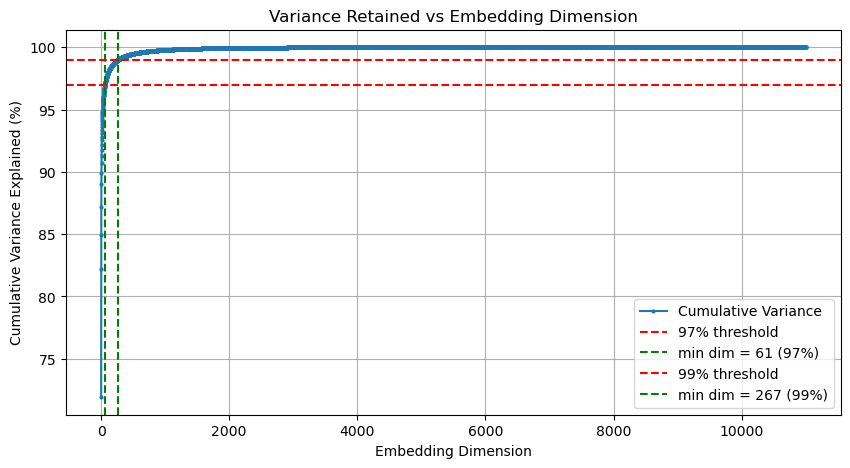

In [ ]:
min_dims, cumulative_variance = plot_variance_vs_dimensions(S)

### Computing Dense Word Embeddings from SVD

We use the precomputed SVD of the Pearson correlation matrix to generate **dense word embeddings**:

- We select the **top `embedding_dim` singular values** and corresponding vectors to form lower-dimensional embeddings:  

$$
\text{Dense vectors} = U_{[:, :d]} \cdot \sqrt{\text{diag}(S_{[:d]})}
$$

- This produces **compact, dense representations** for each word while retaining most of the variance.  


In [ ]:
# Compute dense word embeddings from a correlation matrix using SVD.
def compute_dense_embeddings(corr_matrix=None, embedding_dim=300, U=None, S=None, Vt=None):
    # Compute SVD only if not provided
    if U is None or S is None or Vt is None:
        print("Precompute SVD before computing embeddings")
    else:
        print("Using precomputed SVD.")

    # Compute dense embeddings
    dense_vectors = np.dot(U[:, :embedding_dim], np.diag(np.sqrt(S[:embedding_dim])))

    print(f"Dense word vectors shape: {dense_vectors.shape}")
    return dense_vectors


In [ ]:
dense_vectors_61=compute_dense_embeddings(correlation_matrix,61,U,S,Vt)

Using precomputed SVD.
Dense word vectors shape: (11000, 61)


In [ ]:
dense_vectors_300 = compute_dense_embeddings(correlation_matrix,300,U,S,Vt)

Using precomputed SVD.
Dense word vectors shape: (11000, 300)


In [ ]:
dense_vectors_100 = compute_dense_embeddings(correlation_matrix,100,U,S,Vt)

Using precomputed SVD.
Dense word vectors shape: (11000, 100)


In [ ]:
# Save dense vectors
np.save("D:/CMI/NLP/mr_dense_word_vectors_61.npy", dense_vectors_61)


In [ ]:
# Save dense vectors
np.save("D:/CMI/NLP/mr_dense_word_vectors_300.npy", dense_vectors_300)


In [ ]:
# Save dense vectors
np.save("D:/CMI/NLP/mr_dense_word_vectors_100.npy", dense_vectors_100)


### Finding Similar Words with Dense Embeddings

We compute **top-K similar words** using the dense embeddings obtained from SVD:

- Cosine distance is used as the similarity measure, defined as $( \text{cosine distance} = 1 - \text{cosine similarity} )$.  
- The same target words as in Task 3 are considered.  
- Top 5 words with the **lowest cosine distance** (most similar) are identified for each target word.


In [ ]:
def compute_similar_dense_words(dense_vectors, target_indices, idx2word, top_k=5):
    similar_words = {}

    for pos, indices in target_indices.items():
        similar_words[pos] = {}
        for idx in indices:
            word = idx2word[idx]
            vec = dense_vectors[idx]

            # Cosine similarity with all words
            sims = dense_vectors @ vec / (norm(dense_vectors, axis=1) * norm(vec))

            # Convert similarity to distance
            dists = 1 - sims

            # Exclude self
            dists[idx] = np.inf

            # Top K closest words (smallest distance)
            top_idx = np.argsort(dists)[:top_k]
            similar_words[pos][word] = [(idx2word[i], dists[i]) for i in top_idx]

    return similar_words


In [ ]:
dense_similar_words_61 = compute_similar_dense_words(dense_vectors_61, target_indices, idx2word)


In [ ]:
# Calling the display function
tabulate_similar_words(dense_similar_words_61,mr_to_en)


                                                              NOUNS                                                              


,चित्रपट (movie),गावे (villages),विधानसभा (assembly),फेब्रुवारी (February),गंगू (Gangu)
0,अभिनेत्री (actress) [0.078],रायगड (Raigad) [0.008],मतदारसंघ (constituency) [0.016],नोव्हेंबर (November) [0.012],तेली (Teli) [0.003]
1,बंगाली (Bengali) [0.087],घाडगे (Ghadge) [0.014],निवडणुकीतील (in elections) [0.025],उन्हाळा (summer) [0.036],गांगेय (Gangean) [0.018]
2,अभिनेते (actors) [0.094],सिंधुदुर्ग (Sindhudurg) [0.015],विधानसभेचा (of assembly) [0.029],पावसाळा (monsoon) [0.039],म्हणीमुळे (because of sayings) [0.026]
3,दिग्दर्शक (director) [0.106],रत्‍नागिरी (Ratnagiri) [0.018],कर्नाटकमधील (in Karnataka) [0.031],असतेमार्च (It's March) [0.068],गोष्ट (story) [0.028]
4,गीतकार (songwriter) [0.110],उमरी (Age) [0.018],परिसीमन (delimitation) [0.032],हिवाळा (winter) [0.072],नव्हे (No) [0.030]



                                                              VERBS                                                              


,असते (is/exists),जाते (goes),तयार (ready),गेले (went),करतात (do)
0,गरम (hot) [0.058],असते (is/exists) [0.139],विकसित (developed) [0.076],पहिल्यांदा (for the first time) [0.099],देतात (give) [0.180]
1,सामान्यतः (generally) [0.084],पावसाळ्यात (during monsoon) [0.170],गोळा (collect) [0.087],केल्यावर (after doing) [0.107],परंपरागत (traditional) [0.186]
2,सर्वसाधारण (ordinary) [0.093],व्हिलेजइन्फोइन (village info) [0.178],निर्माण (construction) [0.093],उघडले (opened) [0.112],अन्न (food) [0.210]
3,उष्ण (hot/warm) [0.099],सेलू (Selu) [0.207],निश्चित (certain) [0.096],सामील (included) [0.113],गावकरी (villagers) [0.222]
4,प्रमाणात (in proportion) [0.102],गाव (village) [0.212],दुरुस्त (corrected) [0.104],निपटारा (settlement) [0.116],आणतात (bring) [0.226]



                                                           ADJECTIVES                                                            


,उपलब्ध (available),राष्ट्रीय (national),उष्ण (hot/warm),आंतरराष्ट्रीय (international),मोठे (big)
0,ऑटोरिक्षा (auto-rickshaw) [0.057],काँग्रेस (Congress) [0.193],कोरडे (dry) [0.007],असोसिएट (associate) [0.060],वसवले (settled) [0.054]
1,दूरध्वनी (telephone) [0.067],भारतीय (Indian) [0.200],फारच (very) [0.014],संघांचे (of teams) [0.067],राजाची (of king) [0.085]
2,स्वयंसहाय्य (self-help) [0.070],काँग्रेसच्या (of Congress) [0.205],हवामान (climate) [0.017],क्रिकेटचे (of cricket) [0.070],विद्वान (scholar) [0.086]
3,रेशन (ration) [0.078],काँग्रेसचे (Congress’s) [0.216],वर्षभर (all year) [0.043],देशांतर्गत (domestically) [0.071],सगळ्यात (most) [0.109]
4,तार (wire) [0.082],किसान (farmer) [0.221],वगळता (except) [0.056],खेळाडूंची (of players) [0.074],क्रमांकाचे (numbered) [0.120]


In [ ]:
dense_similar_words_300 = compute_similar_dense_words(dense_vectors_300, target_indices, idx2word)


In [ ]:
# Calling the display function
tabulate_similar_words(dense_similar_words_300,mr_to_en)


                                                              NOUNS                                                              


,चित्रपट (movie),गावे (villages),विधानसभा (assembly),फेब्रुवारी (February),गंगू (Gangu)
0,अभिनेत्री (actress) [0.158],रायगड (Raigad) [0.052],विधानसभेचा (of assembly) [0.031],नोव्हेंबर (November) [0.027],तेली (Teli) [0.006]
1,बंगाली (Bengali) [0.163],सिंधुदुर्ग (Sindhudurg) [0.059],कर्नाटकमधील (in Karnataka) [0.055],हिवाळा (winter) [0.113],गांगेय (Gangean) [0.023]
2,चित्रपटसृष्टीतील (in film industry) [0.192],रत्‍नागिरी (Ratnagiri) [0.060],निवडणुकीतील (in elections) [0.074],पावसाळा (monsoon) [0.164],म्हणीमुळे (because of sayings) [0.037]
3,तेलुगु (Telugu) [0.193],वर्धा (Wardha) [0.062],दिल्लीमधील (in Delhi) [0.081],अखेरपर्यंत (until the end) [0.229],तैलंग (Telang) [0.046]
4,भाषेतील (in language) [0.195],खेड (village) [0.062],मतदारसंघ (constituency) [0.094],हंगाम (season) [0.236],नव्हे (No) [0.046]



                                                              VERBS                                                              


,असते (is/exists),जाते (goes),तयार (ready),गेले (went),करतात (do)
0,विषम (odd) [0.187],खाली (below) [0.395],विकसित (developed) [0.122],वसूल (collected) [0.225],मिळतात (received) [0.345]
1,उष्ण (hot/warm) [0.198],जातेजून (as you go) [0.413],निर्माण (construction) [0.134],निजामाने (by Nizam) [0.261],कुक्कुटपालन (poultry farming) [0.355]
2,सामान्यतः (generally) [0.225],से (as like) [0.444],गोळा (collect) [0.173],कर (tax) [0.261],बकरीपालन (goat farming) [0.362]
3,असतेवार्षिक (annual) [0.227],तापमान (temperature) [0.448],निश्चित (certain) [0.177],सामील (included) [0.273],मोठया (big) [0.393]
4,उन्हाळ्यात (in summer) [0.237],सेल्सियस (Celsius) [0.464],सादर (presented) [0.203],पहिल्यांदा (for the first time) [0.277],वाढत्या (increasing) [0.406]



                                                           ADJECTIVES                                                            


,उपलब्ध (available),राष्ट्रीय (national),उष्ण (hot/warm),आंतरराष्ट्रीय (international),मोठे (big)
0,दूरध्वनी (telephone) [0.196],काँग्रेस (Congress) [0.297],फारच (very) [0.025],हाँग (Hong) [0.154],वसवले (settled) [0.056]
1,मोबाईल (mobile) [0.211],संघ (team) [0.304],कोरडे (dry) [0.027],महिला (women) [0.158],विद्वान (scholar) [0.105]
2,तार (wire) [0.226],काँग्रेसच्या (of Congress) [0.313],उन्हाळ्यात (in summer) [0.070],संघाविरुद्ध (against the team) [0.178],राजाची (of king) [0.112]
3,ऑटोरिक्षा (auto-rickshaw) [0.248],भारतीय (Indian) [0.317],हिवाळ्यात (in winter) [0.089],कसोटी (test) [0.192],आजतागायत (until today) [0.167]
4,गटारव्यवस्था (drainage system) [0.253],काँग्रेसचे (Congress’s) [0.341],हवामान (climate) [0.090],विश्वचषकात (in World Cup) [0.197],क्रमांकाचे (numbered) [0.226]


In [ ]:
dense_similar_words_100 = compute_similar_dense_words(dense_vectors_100, target_indices, idx2word)


In [ ]:
# Calling the display function
tabulate_similar_words(dense_similar_words_100,mr_to_en)


                                                              NOUNS                                                              


,चित्रपट (movie),गावे (villages),विधानसभा (assembly),फेब्रुवारी (February),गंगू (Gangu)
0,अभिनेत्री (actress) [0.102],रायगड (Raigad) [0.013],मतदारसंघ (constituency) [0.023],नोव्हेंबर (November) [0.020],तेली (Teli) [0.002]
1,बंगाली (Bengali) [0.110],सिंधुदुर्ग (Sindhudurg) [0.026],निवडणुकीतील (in elections) [0.025],पावसाळा (monsoon) [0.085],गांगेय (Gangean) [0.007]
2,अभिनेते (actors) [0.123],रत्‍नागिरी (Ratnagiri) [0.027],विधानसभेचा (of assembly) [0.026],उन्हाळा (summer) [0.102],म्हणीमुळे (because of sayings) [0.015]
3,गीतकार (songwriter) [0.131],खेड (village) [0.028],परिसीमन (delimitation) [0.036],हिवाळा (winter) [0.103],तैलंग (Telang) [0.020]
4,हिंदी (Hindi) [0.150],घाडगे (Ghadge) [0.030],कर्नाटकमधील (in Karnataka) [0.037],असतेमार्च (It's March) [0.125],गोष्ट (story) [0.020]



                                                              VERBS                                                              


,असते (is/exists),जाते (goes),तयार (ready),गेले (went),करतात (do)
0,गरम (hot) [0.091],चढते (goes up) [0.223],विकसित (developed) [0.094],केल्यावर (after doing) [0.117],देतात (give) [0.220]
1,विषम (odd) [0.095],असते (is/exists) [0.234],निर्माण (construction) [0.106],वसूल (collected) [0.120],परंपरागत (traditional) [0.257]
2,सामान्यतः (generally) [0.103],पर्यंत (until) [0.242],निश्चित (certain) [0.124],इसवी (AD) [0.135],मिळतात (received) [0.262]
3,उष्ण (hot/warm) [0.131],वर (above) [0.266],गोळा (collect) [0.125],पहिल्यांदा (for the first time) [0.141],शेतकरी (farmer) [0.277]
4,असतेदिवसा (N/A) [0.134],मानवत (humanity) [0.294],दुरुस्त (corrected) [0.136],निजामाने (by Nizam) [0.151],गावकरी (villagers) [0.281]



                                                           ADJECTIVES                                                            


,उपलब्ध (available),राष्ट्रीय (national),उष्ण (hot/warm),आंतरराष्ट्रीय (international),मोठे (big)
0,ऑटोरिक्षा (auto-rickshaw) [0.088],काँग्रेस (Congress) [0.217],कोरडे (dry) [0.008],महिला (women) [0.083],वसवले (settled) [0.040]
1,दूरध्वनी (telephone) [0.090],काँग्रेसच्या (of Congress) [0.224],फारच (very) [0.015],हाँग (Hong) [0.085],राजाची (of king) [0.082]
2,तार (wire) [0.105],भारतीय (Indian) [0.230],हवामान (climate) [0.027],असोसिएट (associate) [0.088],विद्वान (scholar) [0.101]
3,पिन (pin) [0.108],काँग्रेसचे (Congress’s) [0.246],वर्षभर (all year) [0.063],देशांतर्गत (domestically) [0.088],सगळ्यात (most) [0.112]
4,स्वयंसहाय्य (self-help) [0.116],किसान (farmer) [0.252],वगळता (except) [0.064],एकदिवसीय (ODI) [0.096],क्रमांकाचे (numbered) [0.142]


----

### Task 5 Analysis and Report

### Computing Most Dissimilar Words

In this step, we compute the **bottom-K most dissimilar words** for each target word using cosine similarity of word vectors.  
The goal is to identify words that are least similar to a given target word in the embedding space, which can help analyze the semantic structure of the vocabulary and validate the quality of embeddings.

**Key points:**
- We normalize all word vectors to compute `cosine similarity` efficiently.
- For each target word, we calculate cosine similarity with all other words and select the **least similar ones**.
- **Garbage or rare tokens** (e.g., abcता) are filtered out using a regex.  
  Even after preprocessing, such tokens can escape and appear in the vocabulary.  
  Including them could **skew the results** because:
  - They often have extremely low or high similarity by chance.  
  - They do not represent meaningful words in the language.  
- Ensuring only valid language tokens (e.g., Marathi/Devanagari words) keeps the results **clean and interpretable**.

Note: Here we use cosine similarity as a measure which means lower the cosine similarity more dissimilar are the words.

In [ ]:
# For each target word, return bottom_k most dissimilar words along with their cosine similarity.
def compute_most_dissimilar_words(matrix, target_indices, idx2word, bottom_k=5):
    # Normalize vectors
    matrix_norm = matrix / norm(matrix, axis=1, keepdims=True)

    dissimilar_words = {}

    # regex to match valid words for Devanagari / Marathi
    valid_word_pattern = re.compile(r'^[\u0900-\u097F]+$')

    for pos, indices in target_indices.items():
        dissimilar_words[pos] = {}
        for idx in indices:
            word = idx2word[idx]
            vec = matrix_norm[idx]

            # Cosine similarity with all words
            sims = matrix_norm @ vec

            # Exclude self
            sims[idx] = 1.0

            # Filter out invalid / mixed words
            valid_indices = [i for i in range(len(idx2word)) if valid_word_pattern.match(idx2word[i])]
            valid_sims = sims[valid_indices]

            # Get bottom K indices (most negative / least similar)
            bottom_order = valid_sims.argsort()[:bottom_k]
            bottom_idx = [valid_indices[i] for i in bottom_order]

            # Map to words and similarity
            dissimilar_words[pos][word] = [(idx2word[i], sims[i]) for i in bottom_idx]

    return dissimilar_words


In [ ]:
# Single word
single_word_target = {'nouns': [38]}

# Case A
min_sim_caseA = compute_most_dissimilar_words(coals_matrix, single_word_target, idx2word)

# Case B
min_sim_caseB = compute_most_dissimilar_words(dense_vectors_300, single_word_target, idx2word)



### Interpretation of Retaining Negative Correlations in Word Embeddings

When we compare COALS (sparse) embeddings with the dense embeddings from SVD, we notice a clear difference in how they show dissimilarity for the word **"चित्रपट" (movie)**:

**COALS (Sparse Embeddings):**  
- The words that are most "different" from चित्रपट have small positive similarities (e.g., `सुद [0.050]`, `नेतापद [0.051]`).  
- These words are valid Marathi words, but their dissimilarity isn’t very pronounced.

**Dense Embeddings (SVD, with Negative Correlations):**  
- The most dissimilar words now have noticeably negative similarity scores (e.g., `पापिनिएनस [-0.151]`), showing clear semantic opposition.  
- Words like `फेब्रुवारीपर्यंत (until February)` or `शस्त्र (weapon)` are correctly identified as very different from "movie".  
- Keeping negative correlations helps the embeddings capture **contrast** — something the sparse embeddings miss.

**What we can learn from this:**  
1. **Richer meaning:** Negative correlations let the model know not just what is similar, but also what is strongly different.  
2. **Better separation:** Unrelated words are pushed apart in the vector space.  

In short, **retaining negative correlations improves the expressiveness of dense embeddings**, providing clearer distinctions between related and unrelated words, which is especially evident in dissimilarity analysis.

In [ ]:
# Calling the display function
tabulate_similar_words(min_sim_caseA,mr_to_en)


                                                              NOUNS                                                              


,चित्रपट (movie)
0,पापिनिएनस (Unknown) [0.010]
1,सुद (Sud (proper name)) [0.050]
2,नेतापद (leadership post / position) [0.051]
3,नेतानाव (leader name / Chief’s name) [0.051]
4,नव्हे (No) [0.057]


In [ ]:
# Calling the display function
tabulate_similar_words(min_sim_caseB,mr_to_en)


                                                              NOUNS                                                              


,चित्रपट (movie)
0,पापिनिएनस (Unknown) [-0.151]
1,फेब्रुवारीपर्यंत (until February) [-0.020]
2,शस्त्र (weapon / Arms) [-0.019]
3,शास्त्र (science / subject) [-0.018]
4,दोन्हीचा (Of both) [-0.016]


### Summary of Implementation and Challenges

### Task 1: Load and Prepare Co-occurrence Matrix

**Implementation:**  
- Constructed a co-occurrence matrix from the Marathi corpus using a ramped sliding window of size 4.  
- Applied distance-based weighting so that words closer to the target word contribute more strongly to the counts.  
- Limited the vocabulary to 11,000 words (from a possible 20,000) to balance memory usage and computational efficiency.  
- Saved both the matrix and the word-to-index mapping for subsequent tasks.  

**Challenges:**  
- Preprocessing required careful balancing: we aimed to clean the corpus thoroughly while preserving meaningful tokens. Some rare/mixed words naturally remained, but these were minimal and did not impact overall quality.  
- Working with a large vocabulary was memory-intensive; increasing beyond 11,000 words significantly slowed later computations.  

**Findings:**  
- Successfully generated a co-occurrence matrix capturing meaningful relationships between tokens.  
- Sample row checks confirmed that context counts aligned well with expected word co-occurrences, validating the approach.


### Task 2: Parallelize Correlation Computation

**Implementation:**  
- Computed the Pearson correlation coefficient for each row of the co-occurrence matrix against all other rows.  
- Parallelized the row-wise computation using `joblib.Parallel` with 12 cores, significantly reducing runtime compared to sequential execution.  

**Challenges:**  
- Ensuring thread-safe access and efficient memory usage while handling a large matrix.  
- Balancing the number of parallel jobs with system resources to avoid memory overload.  

**Findings:**  
- On a small test (first 5 rows), sequential computation took **13.3 seconds**, while parallel computation completed in **2.88 seconds**.  
- Even on this small scale, parallelization shows clear advantages. When scaled to the full vocabulary (~11,000 words), this approach yields substantial time savings and makes the computation feasible.


### Task 3: Full Pearson Correlation Matrix & COALS Embeddings

**Phase 1: Compute Full Pearson Correlation Matrix**  
- Computed correlations for all vocabulary words (~11,000) using `compute_correlation_row`.  
- Parallelized computation with `joblib.Parallel` using 12 CPU cores to significantly reduce runtime.  
- Resulting correlation matrix shape: (11,000 × 11,000).  
- Time taken: ~57–60 minutes with parallelization (sequential execution would have taken several hours).  
- Saved outputs for later use.



**Phase 2: Generate COALS Word Embeddings**

**Objective:**  
Transform the full Pearson correlation matrix into sparse COALS embeddings that emphasize meaningful co-occurrences while ignoring negative correlations.

**Steps:**  
1. **Zero-out negative correlations:**  
   - Only positive correlations indicate meaningful co-occurrence patterns.  
   - Negative correlations are set to 0 to avoid noise from unrelated word pairs.  

2. **Square root scaling of positive correlations:**  
   - Reduces the impact of extremely high co-occurrence counts.  
   - Moderates the effect of very frequent word pairs.  

3. **L2 Normalization of rows:**  
   - Ensures all word vectors have consistent magnitude.  
   - Facilitates cosine similarity computations for evaluating similarity and dissimilarity.

**Selecting Target Words for Evaluation:**  
- **Nouns:** चित्रपट (movie), गावे (villages), विधानसभा (assembly), फेब्रुवारी (February), गंगू (Gangu)  
- **Verbs:** असते (is/exists), जाते (goes), तयार (prepare), गेले (went), करतात (do)  
- **Adjectives:** उपलब्ध (available), राष्ट्रीय (national), उष्ण (hot), आंतरराष्ट्रीय (international), मोठे (large)  

**Observations:**  
- Top similar words for `फेब्रुवारी (February)`: नोव्हेंबर (November) [0.007], मे (May) [0.023], मार्च (March) [0.026], एप्रिल (April) [0.028], जानेवारी (January) [0.035]  
- Top similar words for `आंतरराष्ट्रीय (international)`: अफगाणिस्तान (Afghanistan) [0.011], स्कॉटलंड (Scotland) [0.012], बल्गेरिया (Bulgaria) [0.012], आयर्लंड (Ireland) [0.012]  
- Top similar word for `असते (is/exists)`: `असतो (is/exists)` [0.064]  
  - This is an **inflectional variant** of the same verb, reflecting Marathi’s rich morphology.  
  - COALS embeddings naturally capture such variants because they appear in **similar syntactic and semantic contexts**.  
  - Handling inflectional languages is challenging since the same base meaning can have many surface forms, but co-occurrence embeddings like COALS can **implicitly cluster these forms together**, improving semantic understanding (depending on the corpus).

**Interpretation:**  
- COALS embeddings capture **contextual similarity** rather than literal meaning.  
- Words appearing in the same contexts are closer in vector space, even if they are not synonyms.  
- Inflectional richness in Marathi is reflected in the embeddings, which helps model semantic patterns despite morphological complexity.  
- This demonstrates the strength of co-occurrence-based embeddings in modeling semantic patterns in Marathi text.



### Task 4: Dense Word Embeddings via SVD

**Objective:**  
Generate dense word embeddings from the Pearson correlation matrix using Singular Value Decomposition (SVD). The goal is to reduce the high-dimensional 11,000-word vector space while retaining most of the semantic information.

**Implementation:**  
1. **Inspect Correlation Matrix:**  
   - Shape: `(11,000 × 11,000)`  
   - Checked min, max, and mean correlations to understand the co-occurrence patterns.  

2. **Compute SVD:**  
   - Applied SVD to decompose the correlation matrix into `U`, `S`, `Vt`.  
   - Explored cumulative variance to determine optimal embedding dimensions:  
     - 97% variance retained with 61 dimensions  
     - 99% variance retained with 267 dimensions  
   - This shows that the 11k-dimensional word space can be compressed significantly without losing most information.  

3. **Compute Dense Embeddings:**  
   - Dense vectors computed as `U[:, :embedding_dim] * sqrt(S[:embedding_dim])`.  
   - Explored embeddings at dimensions 61, 100, and 300 to compare semantic similarity.

**Observations:**  
- **Comparison with COALS embeddings:**  
  - Some nearest neighbors from dense embeddings align with COALS:  
    - `फेब्रुवारी (February)` → `नोव्हेंबर (November)`  
    - `आंतरराष्ट्रीय (International)` → `अफगाणिस्तान (Afghanistan)`, `स्कॉटलंड (Scotland)`  
  - However, dense embeddings also reveal different context-related words not highlighted by COALS:
    - 61-dim:  
      - `आंतरराष्ट्रीय (International)` → `असोसिएट (Associate)`, `संघांचे (Of teams)`, `क्रिकेटचे (Of cricket)`, `देशांतर्गत (Domestically)`, `खेळाडूंची (Of players)`  
      - `फेब्रुवारी (February)` → `नोव्हेंबर (November)`, `हिवाळा (Winter)`, `पावसाळा (Monsoon)`, `असतेमार्च (It's March)`, `हिवाळा (winter)`  
    - 300-dim:  
      - `आंतरराष्ट्रीय (International)` → `हाँग (Hong)`, `महिला (Women)`, `संघाविरुद्ध (Against the team)`, `कसोटी (Test)`, `विश्वचषकात (In World Cup)`  
      - `फेब्रुवारी (February)` → `नोव्हेंबर (November)`, `हिवाळा (Winter)`, `पावसाळा (Monsoon)`, `अखेरपर्यंत (Until the end)`, `हंगाम (Season)`  

- **Insights:**  
  - Dense embeddings capture richer contextual information as dimensions increase, allowing related but not strictly synonymous words to appear as nearest neighbors.  
  - Higher-dimensional embeddings (e.g., 300) reveal more nuanced semantic associations, enhancing potential downstream tasks like clustering, analogy reasoning, or semantic search.

**Conclusion:**  
- Dense embeddings via SVD complement sparse COALS embeddings.  
- Lower dimensions retain core semantic similarity, while higher dimensions capture additional contextual and relational information.  
- This demonstrates a trade-off between compact representation and semantic richness, guiding selection of embedding dimension based on application needs.


###  Summary: Why Retaining Negative Correlations Matters

>- Keeping negative correlations in dense word embeddings lets us capture not just which words are similar, but also which ones are truly different, giving a richer sense of meaning compared to sparse embeddings.  
>- This makes it easier to separate unrelated words, interpret the embeddings more clearly, and use them effectively for tasks like clustering or semantic search.  
>- Comparing COALS and SVD-based embeddings shows that while both pick up some contextual patterns, dense embeddings go a step further, revealing deeper and more nuanced relationships between words.
